<a href="https://colab.research.google.com/github/Ramanaa-Vijayakumar/Smart-Product-Labeling-and-Traceability-System/blob/main/Smart_Product_Traceability_Station_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Smart Product Traceability AI System...
This simulates the complete integration with Arduino hardware
=== Mock Serial Communication Started ===
Simulating Arduino commands...

--- Mock Arduino Command: PRODUCT_DETECTED:PRD1 ---
--- Mock Arduino Command: REQUEST_INSPECTION:PRD1 ---

=== Processing Product: PRD1 ===
Defect Detection: {'defective': False, 'defect_score': 7.0, 'contour_count': 7, 'red_pixels': 0}
RoHS Compliance: True
Inspection Result: PASS
--- AI Response: INSPECTION_RESULT:PASS ---
--- Mock Arduino Command: APPLYING_LABEL:PRD1 ---
--- Mock Arduino Command: VERIFY_LABEL:PRD1 ---

=== Verifying Label for: PRD1 ===
OCR Result: {'valid': True, 'extracted_text': ['Product ID:', 'PRDI', 'Batch: BATCHOQ', 'Device: DEVQQ1', 'Date:', '2025-07-01', 'RoHS:', 'CK'], 'found_fields': ['Product ID', 'Batch', 'Device', 'Date', 'RoHS'], 'confidence_score': 1.0}
Label Verification: PASS
--- AI Response: LABEL_RESULT:PASS ---
--- Final Decision: PASS ---
Logged data for PRD1
--- 

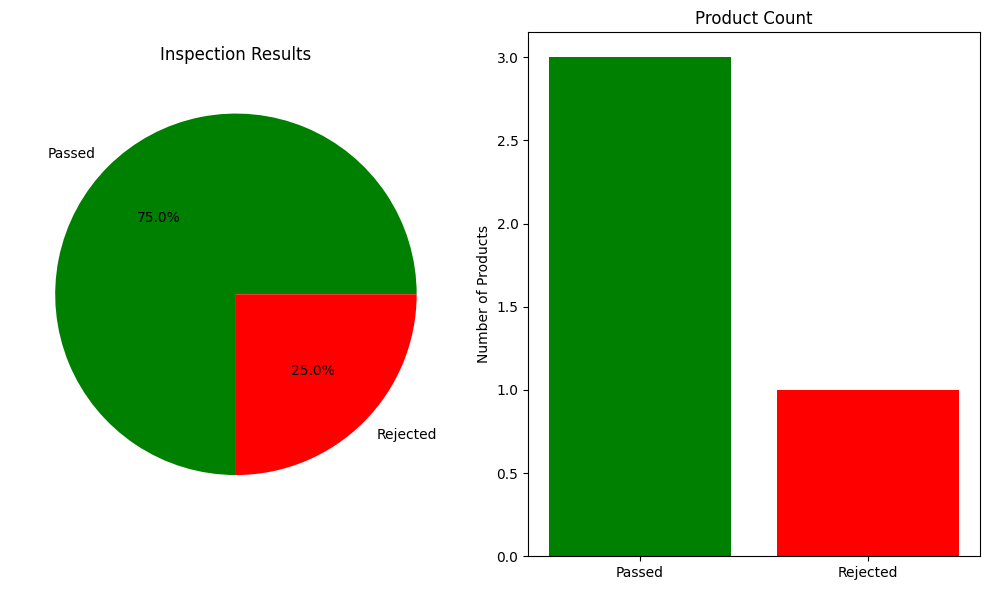


=== AI Module Testing Complete ===
Check 'product_traceability_log.csv' for logged data


In [ ]:
# Smart Product Traceability System - AI Module
# Run this in Google Colab

# Install required libraries
!pip install easyocr opencv-python-headless pillow pandas

import cv2
import numpy as np
import easyocr
import pandas as pd
import json
import time
import os
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random
import threading
import queue

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

class ProductTraceabilityAI:
    def __init__(self):
        self.inspection_results = []
        self.product_database = {}
        self.serial_queue = queue.Queue()
        self.initialize_sample_database()

    def initialize_sample_database(self):
        """Initialize sample product database"""
        self.product_database = {
            'PRD1': {'batch_id': 'BATCH001', 'device_id': 'DEV001', 'mfg_date': '2025-07-01', 'rohs': 'OK'},
            'PRD2': {'batch_id': 'BATCH001', 'device_id': 'DEV002', 'mfg_date': '2025-07-01', 'rohs': 'OK'},
            'PRD3': {'batch_id': 'BATCH002', 'device_id': 'DEV003', 'mfg_date': '2025-07-01', 'rohs': 'OK'},
            'MAN1': {'batch_id': 'BATCH001', 'device_id': 'MAN001', 'mfg_date': '2025-07-01', 'rohs': 'OK'},
        }

    def create_sample_pcb_image(self, width=400, height=300, has_defect=False):
        """Create a sample PCB image for testing"""
        # Create base image
        img = np.zeros((height, width, 3), dtype=np.uint8)
        img[:] = (0, 50, 0)  # Dark green PCB color

        # Add circuit traces (lines)
        for i in range(5):
            start_point = (random.randint(0, width), random.randint(0, height))
            end_point = (random.randint(0, width), random.randint(0, height))
            cv2.line(img, start_point, end_point, (200, 200, 200), 2)

        # Add components (rectangles)
        for i in range(8):
            x = random.randint(20, width-40)
            y = random.randint(20, height-40)
            cv2.rectangle(img, (x, y), (x+20, y+15), (100, 100, 100), -1)

        # Add defects if specified
        if has_defect:
            # Add scratch
            cv2.line(img, (50, 50), (150, 100), (0, 0, 255), 3)
            # Add burn mark
            cv2.circle(img, (300, 200), 15, (0, 0, 100), -1)

        return img

    def create_sample_label(self, product_id, batch_id, device_id, mfg_date, rohs_status):
        """Create a sample product label"""
        # Create white label background
        label = np.ones((150, 300, 3), dtype=np.uint8) * 255

        # Add text information
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        color = (0, 0, 0)
        thickness = 1

        texts = [
            f"Product ID: {product_id}",
            f"Batch: {batch_id}",
            f"Device: {device_id}",
            f"Date: {mfg_date}",
            f"RoHS: {rohs_status}",
            f"QR: {product_id}_{batch_id}"
        ]

        y_offset = 25
        for text in texts:
            cv2.putText(label, text, (10, y_offset), font, font_scale, color, thickness)
            y_offset += 20

        return label

    def detect_defects(self, image):
        """Simple defect detection using image processing"""
        try:
            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply edge detection
            edges = cv2.Canny(gray, 50, 150)

            # Find contours
            contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Simple defect detection logic
            large_contours = [c for c in contours if cv2.contourArea(c) > 100]

            # Check for anomalies
            defect_score = len(large_contours)

            # Check for color anomalies (red areas indicating burns/damage)
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            red_mask = cv2.inRange(hsv, (0, 50, 50), (10, 255, 255))
            red_pixels = cv2.countNonZero(red_mask)

            # Combine scores
            total_defect_score = defect_score + (red_pixels / 100)

            # Determine if defective
            is_defective = total_defect_score > 15

            return {
                'defective': is_defective,
                'defect_score': total_defect_score,
                'contour_count': len(large_contours),
                'red_pixels': red_pixels
            }

        except Exception as e:
            print(f"Error in defect detection: {e}")
            return {'defective': False, 'defect_score': 0, 'contour_count': 0, 'red_pixels': 0}

    def verify_label_ocr(self, label_image):
        """Verify label content using OCR"""
        try:
            # Use EasyOCR to read text
            results = reader.readtext(label_image)

            extracted_text = []
            for (bbox, text, confidence) in results:
                if confidence > 0.5:  # Only keep high confidence results
                    extracted_text.append(text.strip())

            # Join all text
            full_text = ' '.join(extracted_text)

            # Check for required fields
            required_fields = ['Product ID', 'Batch', 'Device', 'Date', 'RoHS']
            found_fields = []

            for field in required_fields:
                if field.lower() in full_text.lower():
                    found_fields.append(field)

            # Label is valid if most required fields are found
            label_valid = len(found_fields) >= 3

            return {
                'valid': label_valid,
                'extracted_text': extracted_text,
                'found_fields': found_fields,
                'confidence_score': len(found_fields) / len(required_fields)
            }

        except Exception as e:
            print(f"Error in OCR verification: {e}")
            return {'valid': False, 'extracted_text': [], 'found_fields': [], 'confidence_score': 0}

    def process_product_inspection(self, product_id):
        """Main product inspection function"""
        print(f"\n=== Processing Product: {product_id} ===")

        # Get product info from database
        if product_id not in self.product_database:
            return "REJECT"  # Unknown product

        product_info = self.product_database[product_id]

        # Simulate product image capture
        # 30% chance of defective product for demo
        has_defect = random.random() < 0.3
        product_image = self.create_sample_pcb_image(has_defect=has_defect)

        # Perform defect detection
        defect_result = self.detect_defects(product_image)
        print(f"Defect Detection: {defect_result}")

        # Check compliance
        compliance_ok = product_info['rohs'] == 'OK'
        print(f"RoHS Compliance: {compliance_ok}")

        # Overall inspection result
        if defect_result['defective'] or not compliance_ok:
            inspection_result = "REJECT"
        else:
            inspection_result = "PASS"

        print(f"Inspection Result: {inspection_result}")

        # Store result for logging
        self.inspection_results.append({
            'product_id': product_id,
            'timestamp': datetime.now().isoformat(),
            'defect_score': defect_result['defect_score'],
            'compliance': compliance_ok,
            'result': inspection_result
        })

        return inspection_result

    def verify_applied_label(self, product_id):
        """Verify the applied label using OCR"""
        print(f"\n=== Verifying Label for: {product_id} ===")

        if product_id not in self.product_database:
            return "REJECT"

        product_info = self.product_database[product_id]

        # Create sample label image
        label_image = self.create_sample_label(
            product_id,
            product_info['batch_id'],
            product_info['device_id'],
            product_info['mfg_date'],
            product_info['rohs']
        )

        # Add some noise to simulate real-world conditions
        if random.random() < 0.2:  # 20% chance of poor label quality
            noise = np.random.normal(0, 10, label_image.shape).astype(np.uint8)
            label_image = cv2.add(label_image, noise)

        # Perform OCR verification
        ocr_result = self.verify_label_ocr(label_image)
        print(f"OCR Result: {ocr_result}")

        # Determine label verification result
        if ocr_result['valid'] and ocr_result['confidence_score'] > 0.6:
            label_result = "PASS"
        else:
            label_result = "REJECT"

        print(f"Label Verification: {label_result}")
        return label_result

    def log_product_data(self, log_data):
        """Log product data to CSV file"""
        try:
            # Parse log data
            parts = log_data.split(',')
            if len(parts) >= 6:
                log_entry = {
                    'product_id': parts[0],
                    'batch_id': parts[1],
                    'mfg_date': parts[2],
                    'rohs_status': parts[3],
                    'inspection_result': parts[4],
                    'timestamp': parts[5],
                    'logged_at': datetime.now().isoformat()
                }

                # Save to CSV
                df = pd.DataFrame([log_entry])
                df.to_csv('product_traceability_log.csv', mode='a', header=False, index=False)
                print(f"Logged data for {parts[0]}")

        except Exception as e:
            print(f"Error logging data: {e}")

    def simulate_serial_communication(self):
        """Simulate Arduino serial communication"""
        print("=== Mock Serial Communication Started ===")
        print("Simulating Arduino commands...")

        # Simulate some product inspections
        test_products = ['PRD1', 'PRD2', 'PRD3', 'MAN1']

        for product_id in test_products:
            print(f"\n--- Mock Arduino Command: PRODUCT_DETECTED:{product_id} ---")
            time.sleep(1)

            print(f"--- Mock Arduino Command: REQUEST_INSPECTION:{product_id} ---")
            inspection_result = self.process_product_inspection(product_id)
            print(f"--- AI Response: INSPECTION_RESULT:{inspection_result} ---")
            time.sleep(1)

            print(f"--- Mock Arduino Command: APPLYING_LABEL:{product_id} ---")
            time.sleep(2)

            print(f"--- Mock Arduino Command: VERIFY_LABEL:{product_id} ---")
            label_result = self.verify_applied_label(product_id)
            print(f"--- AI Response: LABEL_RESULT:{label_result} ---")
            time.sleep(1)

            # Final decision
            final_result = "PASS" if inspection_result == "PASS" and label_result == "PASS" else "REJECT"
            print(f"--- Final Decision: {final_result} ---")

            # Log data
            log_data = f"{product_id},BATCH001,2025-07-01,RoHS_OK,{final_result},{int(time.time())}"
            self.log_product_data(log_data)

            print(f"--- Mock Arduino Response: PRODUCT_{final_result}:{product_id} ---")
            time.sleep(2)
            print("--- Mock Arduino: READY_FOR_NEXT ---")
            time.sleep(1)

    def display_results_summary(self):
        """Display inspection results summary"""
        if self.inspection_results:
            df = pd.DataFrame(self.inspection_results)
            print("\n=== INSPECTION RESULTS SUMMARY ===")
            print(df.to_string(index=False))

            # Display statistics
            total_products = len(df)
            passed_products = len(df[df['result'] == 'PASS'])
            rejected_products = len(df[df['result'] == 'REJECT'])

            print(f"\n=== STATISTICS ===")
            print(f"Total Products Inspected: {total_products}")
            print(f"Passed: {passed_products} ({passed_products/total_products*100:.1f}%)")
            print(f"Rejected: {rejected_products} ({rejected_products/total_products*100:.1f}%)")

            # Plot results
            plt.figure(figsize=(10, 6))

            plt.subplot(1, 2, 1)
            plt.pie([passed_products, rejected_products],
                   labels=['Passed', 'Rejected'],
                   colors=['green', 'red'],
                   autopct='%1.1f%%')
            plt.title('Inspection Results')

            plt.subplot(1, 2, 2)
            plt.bar(['Passed', 'Rejected'], [passed_products, rejected_products],
                   color=['green', 'red'])
            plt.title('Product Count')
            plt.ylabel('Number of Products')

            plt.tight_layout()
            plt.show()

# Initialize the AI system
ai_system = ProductTraceabilityAI()

# Run the simulation
print("Starting Smart Product Traceability AI System...")
print("This simulates the complete integration with Arduino hardware")

# Run the mock serial communication
ai_system.simulate_serial_communication()

# Display results
ai_system.display_results_summary()

print("\n=== AI Module Testing Complete ===")
print("Check 'product_traceability_log.csv' for logged data")